<a href="https://colab.research.google.com/github/junfrankohara/git-practice/blob/main/goblet_cell_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Load images and models

In [1]:
import urllib.request
%cd /content/
%mkdir gob
print("サンプル画像のダウンロード...")
sample_url = "https://github.com/junfrankohara/goblet_cell_detection/blob/main/sample.png?raw=true"
urllib.request.urlretrieve(sample_url, './gob/sample.png')
print("セグメンテーションモデル1のダウンロード...")
seg1_url = "https://github.com/junfrankohara/goblet_cell_detection/releases/download/segmentation/model1.pth"
urllib.request.urlretrieve(seg1_url, './gob/model1.pth')
print("セグメンテーションモデル2のダウンロード...")
seg2_url = "https://github.com/junfrankohara/goblet_cell_detection/releases/download/segmentation/model2.pth"
urllib.request.urlretrieve(seg2_url, './gob/model2.pth')
%ls /content/gob

/content
mkdir: cannot create directory ‘gob’: File exists
サンプル画像のダウンロード...
セグメンテーションモデル1のダウンロード...
セグメンテーションモデル2のダウンロード...
model1.pth  model2.pt  model2.pth  sample.png


Install segmentation models

In [3]:
pip install torch==1.9.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
pip install torchvision==0.10.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
pip install segmentation_models_pytorch==0.2.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
from skimage.transform import rescale, resize
from tqdm import tqdm
import torch
import segmentation_models_pytorch as smp
import google.colab
import googleapiclient.discovery
import googleapiclient.http
from pylab import rcParams
rcParams['figure.figsize'] = 20,10
from PIL import Image

ENCODER = 'efficientnet-b4'
ENCODER_WEIGHTS = 'imagenet'
ACTIVATION = 'softmax2d'
DEVICE = 'cuda'

*   Mount your Google drive.
*   To run this cord, you need to upload models and images(model1.pth, model2.pth and remission_case.png) onto your Google Drive.



In [6]:
%ls /content/gob

model1.pth  model2.pt  model2.pth  sample.png


In [7]:
# Create segmentation model with pretrained encoder
model = smp.FPN(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=4, #len(CLASSES), 
    activation=ACTIVATION,
)

#　Load model1 and model2
preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)
model1 = torch.load('/content/gob/model1.pth')
model2 = torch.load('/content/gob/model2.pth')

/usr/local/lib/python3.9/dist-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'segmentation_models_pytorch.fpn.model.FPN' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.9/dist-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'segmentation_models_pytorch.encoders.efficientnet.EfficientNetEncoder' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.9/dist-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'torch.nn.modules.padding.ZeroPad2d' has changed. you can retrieve the original source code by 

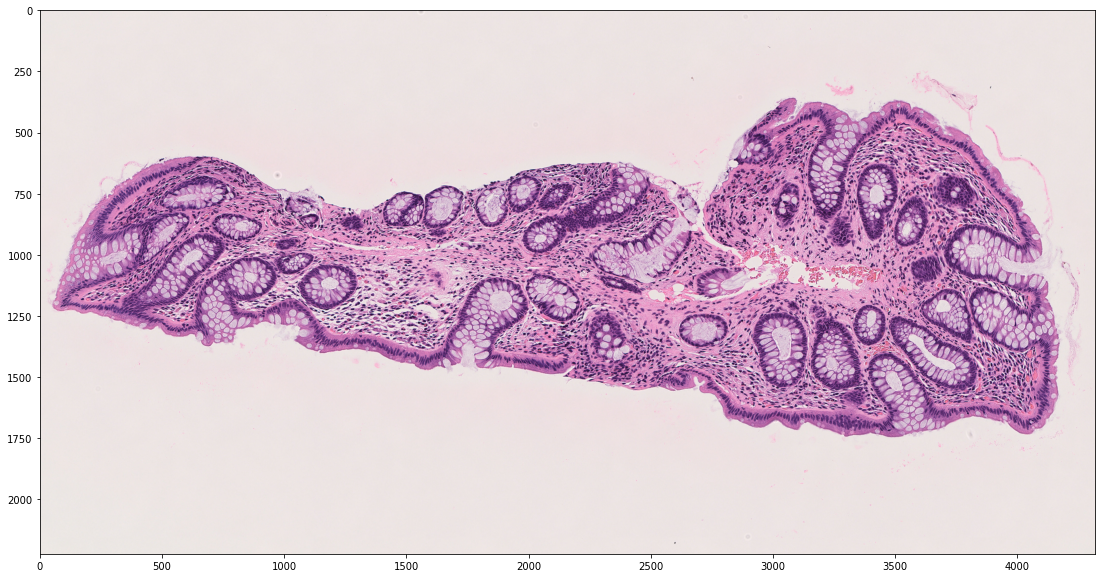

In [8]:
#Load image
img_path='/content/gob/sample.png'
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)


100%|██████████| 72/72 [00:02<00:00, 30.41it/s]


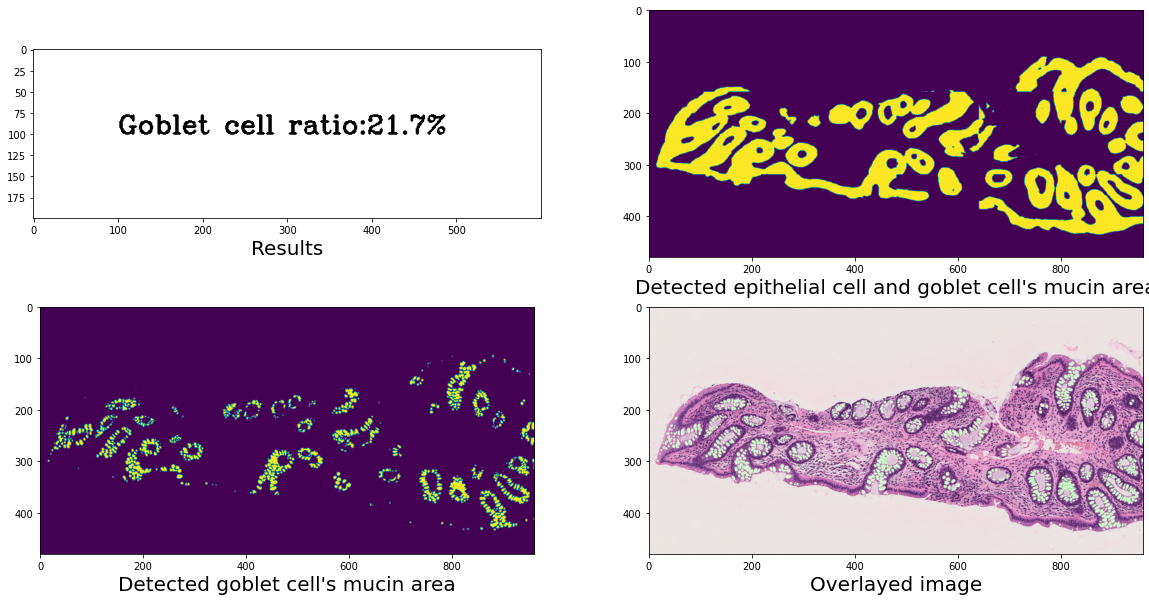

In [9]:
def crop_to_640pix(img):
    """Crops image to size of 640x640pix images."""
    crop_array=img.reshape(int(img.shape[0]/640),640,int((img.shape[1])/640),640, 3)
    crop_array=crop_array.transpose([0,2,1,3,4])
    crop_array=crop_array.reshape(-1,640,640,3)
    return crop_array

def assemble_with640pix(crop_arrays, img_height, img_width):
    """Assembles size of 640x640pix predicted images into a large image that indicates epithelial cells and goblet cell mucin's area."""
    re_x=crop_arrays.reshape(int(img_height/640),int(img_width/640),640,640)
    re_x=re_x.transpose([0,2,1,3])
    return re_x.reshape(img_height, img_width).astype("uint8")

def crop_to_320pix(img):
    """Crops image to size of 320x320pix images."""
    crop_array=img.reshape(int(img.shape[0]/320),320,int((img.shape[1])/320),320, 3)
    crop_array=crop_array.transpose([0,2,1,3,4])
    crop_array=crop_array.reshape(-1,320,320,3)
    return crop_array

def assemble_with320pix(crop_arrays, img_height, img_width):
    """Assembles size of 320x320pix predicted images into a large image that indicates goblet cell mucin's area."""
    re_x=crop_arrays.reshape(int(img_height/320),int(img_width/320),320,320)
    re_x=re_x.transpose([0,2,1,3])
    return re_x.reshape(img_height, img_width).astype("uint8")


#Makes image shape divisible by 640pix.
img=img[:int(img.shape[0]/640)*640, :int(img.shape[1]/640)*640,:]
img_height=img.shape[0]
img_width=img.shape[1]
#Crops image to size of 640x640pix images.
crop_array=crop_to_640pix(img)
epithelium_list=[]

#Adopt cropped images to model1 for predicting epithelial cell and goblet cell's mucin area.
for rgb in tqdm(crop_array):
    half_rgb=resize(rgb, (320, 320), anti_aliasing=True)
    image = preprocessing_fn(half_rgb)
    image = image.transpose(2, 0, 1).astype('float32')
    image=torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    predict = model1(image)
    predict = predict.detach().cpu().numpy()[0]
    pr_epithelium=predict[3,:,:]
    pr_epithelium = np.where(pr_epithelium>0.7, 1, 0)
    pr_epithelium=pr_epithelium.repeat(2, axis=0).repeat(2, axis=1)
    epithelium_list.append(pr_epithelium)
epithelium_arrays=np.stack(epithelium_list)
#Assemble size of 640x640pix predicted images into a large image that indicates epithelial cells and goblet cell's mucin area.
detect_epithelium=assemble_with640pix(epithelium_arrays, img_height, img_width)
detect_epithelium3=np.stack([detect_epithelium,detect_epithelium,detect_epithelium], axis=-1).astype("uint8")
#Generate predicted epithelial cells and goblet cell's mucin images.
epithelium_img=img*detect_epithelium3
#Crop predicted image to size of 320x320pix images.
epithelium_crops=crop_to_320pix(epithelium_img)
goblet_list=[]
#Adopt cropped images to model2 for predicting goblet cell's mucin area.
for crop in tqdm(epithelium_crops):
    image = preprocessing_fn(crop)
    image = image.transpose(2, 0, 1).astype('float32')
    image=torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    predict = model2(image)
    predict = predict.detach().cpu().numpy()[0]
    pr_goblet=predict[2,:,:]
    pr_goblet = np.where(pr_goblet>0.7, 1, 0)
    goblet_list.append(pr_goblet)
goblet_arrays=np.stack(goblet_list)
#Assemble size of 320x320pix predicted images into a large image that indicates goblet cell's mucin area.
detect_goblet=assemble_with320pix(goblet_arrays, img_height, img_width)
#Calculate the area of epithelial cells and goblet cell's mucin.
epithelium_bins=np.bincount(detect_epithelium.astype("uint8").flatten())[1]
#Calculate the area of goblet cell's mucin.
goblet_bins=np.bincount(detect_goblet.astype("uint8").flatten())[1]
#Generate overlayed image
goblet_arrays_255=detect_goblet.astype("uint8")*255
mask_color=np.stack([np.zeros(detect_goblet.shape), goblet_arrays_255, np.zeros(detect_goblet.shape)], axis=-1)
goblet_filt=np.where(mask_color>0, True, False)
overlay=np.where(goblet_filt, (0.9*mask_color+0.1*img).astype(np.uint8), img)
overlay=resize(overlay, (overlay.shape[0] / 4, overlay.shape[1] / 4), anti_aliasing=True)
#Calculate "goblet cell ratio".
results=np.ones((200,600,3))
results=cv2.putText(results,text='Goblet cell ratio:{}%'.format(round(goblet_bins/epithelium_bins*100,2)),org=(100, 100),fontFace=cv2.FONT_HERSHEY_COMPLEX, fontScale=1.0, color=(0, 0, 0),thickness=2,lineType=cv2.LINE_4)
#Display generated images
fig, axes = plt.subplots(nrows=2, ncols=2)
axes[0, 0].imshow(results)
axes[0, 0].set_xlabel('Results', fontsize=20)
axes[0, 1].imshow(resize(detect_epithelium, (detect_epithelium.shape[0] / 4, detect_epithelium.shape[1] / 4), anti_aliasing=True))
axes[0, 1].set_xlabel("Detected epithelial cell and goblet cell's mucin area", fontsize=20)
axes[1, 0].imshow(resize(detect_goblet, (detect_goblet.shape[0] / 4, detect_goblet.shape[1] / 4), anti_aliasing=True))
axes[1, 0].set_xlabel("Detected goblet cell's mucin area", fontsize=20)
axes[1, 1].set_xlabel("Overlayed image", fontsize=20)
axes[1, 1].imshow(overlay)